# Conclusion: hacky fix by rotating the individual tiles by 90 degrees counterclockwise

Need to interogate why this is the case...

Also include more overlap and smoothing?

In [3]:
import numpy as np
import glob
import os
from skimage.io import imread
import dask
from functools import partial
import numpy as np
from typing import Tuple, List, Dict, Union, Optional, Callable
from dask.array.core import normalize_chunks
import dask
import dask.array as da
import glob
import os
from skimage.io import imread, imsave
from skimage.transform import AffineTransform
from scipy.ndimage import affine_transform
from pathlib import Path
import pkg_resources
pkg_resources.require("Shapely<2.0.0")
import shapely
from shapely.geometry.base import BaseGeometry
from shapely.geometry.polygon import Polygon
from shapely.geometry import LineString
from shapely.strtree import STRtree
import pandas as pd
from functools import partial
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [4]:
from octopuslite import utils, tile

In [5]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


In [6]:
metadata

id State                              URL Row Col FieldID  \
0        0303K1F1P1R1    Ok   r03c03f01p01-ch1sk1fk1fl1.tiff   3   3       1   
1        0303K1F1P1R2    Ok   r03c03f01p01-ch2sk1fk1fl1.tiff   3   3       1   
2        0303K1F1P2R1    Ok   r03c03f01p02-ch1sk1fk1fl1.tiff   3   3       1   
3        0303K1F1P2R2    Ok   r03c03f01p02-ch2sk1fk1fl1.tiff   3   3       1   
4        0303K1F1P3R1    Ok   r03c03f01p03-ch1sk1fk1fl1.tiff   3   3       1   
...               ...   ...                              ...  ..  ..     ...   
113395  0609K75F9P1R2    Ok  r06c09f09p01-ch2sk75fk1fl1.tiff   6   9       9   
113396  0609K75F9P2R1    Ok  r06c09f09p02-ch1sk75fk1fl1.tiff   6   9       9   
113397  0609K75F9P2R2    Ok  r06c09f09p02-ch2sk75fk1fl1.tiff   6   9       9   
113398  0609K75F9P3R1    Ok  r06c09f09p03-ch1sk75fk1fl1.tiff   6   9       9   
113399  0609K75F9P3R2    Ok  r06c09f09p03-ch2sk75fk1fl1.tiff   6   9       9   

       PlaneID TimepointID ChannelID FlimID  ... PositionZ AbsPositionZ  \
0            1           0         1      1  ...         0  0.135583505   
1            1           0         2      1  ...         0  0.135583505   
2            2           0         1      1  ...     2E-06  0.135585502   
3            2           0         2      1  ...     2E-06  0.135585502   
4            3           0         1      1  ...     4E-06  0.135587499   
...        ...         ...       ...    ...  ...       ...          ...   
113395       1          74         2      1  ...         0  0.135533601   
113396       2          74         1      1  ...     2E-06  0.135535598   
113397       2          74         2      1  ...     2E-06  0.135535598   
113398       3          74         1      1  ...     4E-06  0.135537595   
113399       3          74         2      1  ...     4E-06  0.135537595   

       MeasurementTimeOffset                        AbsTime  \
0                          0   2021-04-16T19:09:33.84+01:00   
1                          0   2021-04-16T19:09:33.84+01:00   
2                          0   2021-04-16T19:09:34.12+01:00   
3                          0   2021-04-16T19:09:34.12+01:00   
4                          0    2021-04-16T19:09:34.4+01:00   
...                      ...                            ...   
113395             266399.61  2021-04-19T21:14:19.477+01:00   
113396             266399.61  2021-04-19T21:14:19.757+01:00   
113397             266399.61  2021-04-19T21:14:19.757+01:00   
113398             266399.61  2021-04-19T21:14:20.037+01:00   
113399             266399.61  2021-04-19T21:14:20.037+01:00   

       MainExcitationWavelength MainEmissionWavelength ObjectiveMagnification  \
0                           488                    522                     40   
1                           640                    706                     40   
2                           488                    522                     40   
3                           640                    706                     40   
4                           488                    522                     40   
...                         ...                    ...                    ...   
113395                      640                    706                     40   
113396                      488                    522                     40   
113397                      640                    706                     40   
113398                      488                    522                     40   
113399                      640                    706                     40   

       ObjectiveNA ExposureTime  \
0              1.1          0.1   
1              1.1          0.2   
2              1.1          0.1   
3              1.1          0.2   
4              1.1          0.1   
...            ...          ...   
113395         1.1          0.2   
113396         1.1          0.1   
113397         1.1          0.2   
113398         1.1          0.1   
113399         1.1          0.2   

      

In [7]:
df = metadata

In [8]:
time = 0
plane = 1
channel = 1
row = 3
col = 5
chunk_fraction = 9
input_transforms = None

In [15]:
transforms

[array([[ 1.00000000e+00, -0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  3.88800167e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -0.00000000e+00, -1.94399749e+03],
        [ 0.00000000e+00,  1.00000000e+00,  7.77599665e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  7.77599665e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -0.00000000e+00,  1.94399749e+03],
        [ 0.00000000e+00,  1.00000000e+00,  7.77599665e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -0.00000000e+00,  1.94399749e+03],
        [ 0.00000000e+00,  1.00000000e+00,  5.83199916e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -0.00000000e+00,  0.00000000e+00],
        [ 0.00

In [17]:
view(imread(fns[0]))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f1b2d0c54c0>

In [14]:
load_transform_image = partial(load_image, transforms=input_transforms)
filtered_df = df[(df['TimepointID'] == str(time))
               &(df['PlaneID'] == str(plane))
               &(df['ChannelID'] == str(channel))
               &(df['Row'] == str(row))
               &(df['Col'] == str(col))
                ]
### extract filenames for subset
fns = filtered_df['URL']
### build into full file path
fns = [glob.glob(os.path.join(image_dir, fn))[0] for fn in fns]
### stack single slice mosaic into lazy array
sample = imread(fns[0])
lazy_arrays = [dask.delayed(imread)(fn) for fn in fns]
lazy_arrays = [dask.array.from_delayed(x, shape=sample.shape, dtype=sample.dtype)
               for x in lazy_arrays]
### define the function to fuse the image
_fuse_func=partial(fuse_func,
                   imload_fn=load_transform_image,
                   dtype=sample.dtype)
### extract and convert coordinates from standard units into pixels
coords = filtered_df[["URL", "PositionX", "PositionY", "PositionZ",
"ImageResolutionX", "ImageResolutionY"]]
coords['PositionXPix'] = (coords['PositionX'].astype(float))/(coords['ImageResolutionX']).astype(float)
coords['PositionYPix'] = (coords['PositionY'].astype(float))/(coords['ImageResolutionY']).astype(float)
norm_coords = list(zip(coords['PositionXPix'], coords['PositionYPix']))
### convert tile coordinates into transformation matrices
transforms = [AffineTransform(translation=stage_coord).params for stage_coord in norm_coords]
tiles = [transform_tile_coord(sample.shape, transform) for transform in transforms]
### shift the tile coordinates to the origin
all_bboxes = np.vstack(tiles)
all_min = all_bboxes.min(axis=0)
all_max = all_bboxes.max(axis=0)
stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))
shift_to_origin = AffineTransform(translation=-all_min)
transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
shifted_tiles = [transform_tile_coord(sample.shape, t) for t in transforms_with_shift]
### decide on chunk size as a fraction of total slice size TODO: auto size, assuming symmetric atm
chunk_size = (stitched_shape[0]/np.sqrt(chunk_fraction),stitched_shape[0]/np.sqrt(chunk_fraction))
chunks = normalize_chunks(chunk_size,shape=tuple(stitched_shape))
### check the maths adds up correctly (chunks fit into mosaic)
computed_shape = np.array(list(map(sum, chunks)))
assert np.all(np.array(stitched_shape) == computed_shape)
### get boundary coords of chunks
chunk_boundaries = list(get_chunk_coord(stitched_shape, chunk_size))
### use shapely to find the intersection of the chunks
tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]
### is the coordinate conversions between numpy and shapely causing the issue?
# tiles_shifted_shapely = [Polygon(s) for s in shifted_tiles]
chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]
# chunks_shapely = [Polygon(c) for c in chunk_shapes]
### build dictionary of chunk shape data with filenames and transformations
for tile_shifted_shapely, file, transform in zip(tiles_shifted_shapely,
                                     fns,
                                     transforms_with_shift):
    tile_shifted_shapely.fuse_info = {'file':file,
                                      'transform':transform}
for chunk_shapely, chunk_boundary in zip(chunks_shapely,
                                          chunk_boundaries):
    chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}
chunk_tiles = find_chunk_tile_intersections(tiles_shifted_shapely, chunks_shapely)
### tile images together
frame = dask.array.map_blocks(func=_fuse_func,
         chunks=chunks,
         input_tile_info=chunk_tiles,
         dtype=sample.dtype)
view(frame)

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f1b27c3f040>

In [19]:
view(np.rot90(frame))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f1b3438c670>

In [9]:
FilePath = Union[Path, str]
ArrayLike = Union[
    np.ndarray, "dask.array.Array"
]  # could add other array types if needed

def load_image(
    file: FilePath, transforms: List[Callable[[ArrayLike], ArrayLike]] = None
) -> np.ndarray:
    img = np.rot90(imread(file), k = 3)
    # if img.ndim == 2:
    #    img = np.expand_dims(img, axis=0)
    if transforms is not None:
        for t in transforms:
            img = t(img)
    return img

In [10]:
import napari
def view(img):
    return napari.Viewer().add_image(img)

In [11]:
def transform_tile_coord(shape: Tuple[int,int], affine_matrix: np.ndarray) -> np.ndarray:
    """
    returns the corner coordinates of a 2D array with shape shape
    after applying the transform represented by affine_matrix.
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    h, w = shape
    # create homogeneous coordinates for corner points
    baserect = np.array([[0, 0], [h, 0], [h, w], [0, w]])
    augmented_baserect = np.concatenate(
        (baserect, np.ones((baserect.shape[0], 1))), axis=1
    )
    # see where the corner points map to
    transformed_rect = (affine_matrix @ augmented_baserect.T).T[:, :-1]
    return transformed_rect

def get_chunk_coord(shape: Tuple[int, int], chunk_size: Tuple[int, int]):
    """Iterator that returns the bounding coordinates
    for the individual chunks of a dask array of size
    shape with chunk size chunk_size.


    return_np_slice determines the output format. If True,
    a numpy slice object is returned for each chunk, that can be used
    directly to slice a dask array to return the desired chunk region.
    If False, a Tuple of Tuples ((row_min, row_max+1),(col_min, col_max+1))
    is returned.
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)

    """
    chunksy, chunksx = normalize_chunks(chunk_size, shape=shape)
    y = 0
    for cy in chunksy:
        x = 0
        for cx in chunksx:
            yield ((y, y + cy), (x, x + cx))
            x = x + cx
        y = y + cy

def numpy_shape_to_shapely(coords: np.ndarray, shape_type: str = "polygon") -> BaseGeometry:
    """
    Convert an individual shape represented as a numpy array of coordinates
    to a shapely object
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    _coords = coords[:, ::-1].copy()  # shapely has col,row order, numpy row,col
    _coords[:, 1] *= -1  # axis direction flipped between shapely and napari
    if shape_type in ("rectangle", "polygon", "ellipse"):
        return Polygon(_coords)
    elif shape_type in ("line", "path"):
        return LineString(_coords)
    else:
        raise ValueError

def get_rect_from_chunk_boundary(chunk_boundary):
    """given a chunk boundary tuple, return a numpy
    array that can be added as a shape to napari"
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    ylim, xlim = chunk_boundary
    miny, maxy = ylim[0], ylim[1] - 1
    minx, maxx = xlim[0], xlim[1] - 1
    return np.array([[miny, minx], [maxy, minx], [maxy, maxx], [miny, maxx]])

def find_chunk_tile_intersections(
    tiles_shapely: List["shapely.geometry.base.BaseGeometry"],
    chunks_shapely: List["shapely.geometry.base.BaseGeometry"],
) -> Dict[Tuple[int, int], Tuple[str, np.ndarray]]:
    """
    For each output array chunk, find the intersecting image tiles

    Args:
        tile_shapes: Contains the shapely objects corresponding to transformed image outlines.
                    Each shape in tile_shapes must have a .fuse_info dictionary with
                    keys "file" and "transform".
        chunk_shapes: Contains the shapely objects representing dask array chunks.
                    Each shape in chunk_shapes must have a .fuse_info dictionary with
                    key "chunk_boundary", containing a tuple of chunk boundaries

    Returns:
         The chunk_to_tiles dictionary, which has the chunk anchor points as keys and tuples of350
         image file names and their corresponding affine transform matrix as values.
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    chunk_to_tiles = {}
    tile_tree = STRtree(tiles_shapely)

    for chunk_shape in chunks_shapely:
        chunk_boundary = chunk_shape.fuse_info["chunk_boundary"]
        anchor_point = (chunk_boundary[0][0], chunk_boundary[1][0])
        intersecting_tiles = tile_tree.query(chunk_shape)
        chunk_to_tiles[anchor_point] = [
            ((t.fuse_info["file"], t.fuse_info["transform"]))
            for t in intersecting_tiles
        ]
    return chunk_to_tiles


In [12]:
def fuse_func(
    input_tile_info: Dict[
        Tuple[int, int], List[Tuple[Union[str, Path, np.ndarray], np.ndarray]]
    ],
    imload_fn: Optional[Callable] = imread,
    block_info=None,
    dtype=np.uint16,
) -> np.ndarray:

    """
    Fuses the tiles that intersect the current chunk of a dask array using maximum projection.

    Pass this function to dask.array.map_blocks, after partial evaluation of the required
    image_folder and (if needed) optional arguments.

    Returns:
        Array of chunk-shape containing max projection of tiles falling into chunk

    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    array_location = block_info[None]["array-location"]
    # The anchor point is the key to the input_tile_info dictionary
    anchor_point = (array_location[0][0], array_location[1][0])
    chunk_shape = block_info[None]["chunk-shape"]
    tiles_info = input_tile_info[anchor_point]
    #print(f"Processing chunk at {anchor_point}")
    fused = np.zeros(chunk_shape, dtype=dtype)
    for image_representation, tile_affine in tiles_info:
        if imload_fn is not None:
            # When imload_fn is provided we assume we have been given strings representing files
            tile_path = image_representation
            im = imload_fn(tile_path)
        else:
            # Without imload function we assume images are passed
            im = image_representation
        shift = AffineTransform(translation=(-anchor_point[0], -anchor_point[1]))
        tile_shifted = affine_transform(
            im,
            matrix=np.linalg.inv(shift.params @ tile_affine),
            output_shape=chunk_shape,
            cval=0,
        )
        # note that the dtype comversion here happens without scaling
        # may want to use one of the skimage.img_as_* functions instead
        stack = np.stack([fused, tile_shifted.astype(dtype)])
        fused = np.max(stack, axis=0)
    return fused

In [13]:
def stitch(load_transform_image:partial,
    df: pd.DataFrame,
    image_dir: os.PathLike,
    time:int,
    plane:int,
    channel:int,
    row:int,
    col:int,
    chunk_fraction:int,
    mask:bool)-> dask.array:
    """
    Function that takes DaskFusion core elements, defined above and uses them to
    stitch a single-frame/slice mosaic image together.

    Parameters
    ----------
    load_transform_image: partial function
        Partial function that loads the image along with any transformations
    df : pd.DataFrame
        Pandas DataFrame containing all of the image metadata, taken from
        utils.read_harmony_metadata
    time : int
        Time index, taken from utils.read_harmony_metadata dataframe output.
    plane : int
        Z index, taken from utils.read_harmony_metadata dataframe output.
    channel : int
        Channel index, taken from utils.read_harmony_metadata dataframe output.
    row : int
        Row index, taken from utils.read_harmony_metadata dataframe output.
        Encodes the row of the FOV that you want to tile into a mosaic.
    col : int
        Column index, taken from utils.read_harmony_metadata dataframe output.
        Encodes the row of the FOV that you want to tile into a mosaic.
    chunk_fraction : int
        How many Dask array chunks you want to divide the mosaic image into,
        must be a square number as the images are symmetric.
    mask : bool
        If true then the filenames are replaced with ch99 enumeration, which
        corresponds to a mask image for the set time and plane
        THIS IS THE WRONG APPROACH FOR MASKS...

    Returns
    -------
    frame : dask.array
        An stitched mosaic image for the given indices provided as the params,
        but only actually stitched together when the image is calculated.
    tiles_shifted_shapely: list of shapely.geometry.polygon.Polygon
        Chunk information can be extracted to save out individual mask tiles.
    """

    ### extract metadata for this mosaic
    filtered_df = df[(df['TimepointID'] == str(time))
                   &(df['PlaneID'] == str(plane))
                   &(df['ChannelID'] == str(channel))
                   &(df['Row'] == str(row))
                   &(df['Col'] == str(col))
                    ]
    ### extract filenames for subset
    fns = filtered_df['URL']
    ### if you want to stitch the masks together then only extract the mask fns
    if mask:
        ### check that all masks are present
        masks_exist = all([os.path.exists(os.path.join(image_dir, fn)) for fn in
                            fns.str.replace(r'ch(\d+)', 'ch99', regex = True)])
        assert masks_exist == True, "Cannot find all corresponding masks"
        ### this is achieved by replacing the
        fns = fns.str.replace(r'ch(\d+)', 'ch99', regex = True)
    ### build into full file path
    fns = [glob.glob(os.path.join(image_dir, fn))[0] for fn in fns]
    ### stack single slice mosaic into lazy array
    sample = imread(fns[0])
    lazy_arrays = [dask.delayed(imread)(fn) for fn in fns]
    lazy_arrays = [da.from_delayed(x, shape=sample.shape, dtype=sample.dtype)
                   for x in lazy_arrays]

    ### define the function to fuse the image
    _fuse_func=partial(fuse_func,
                       imload_fn=load_transform_image,
                       dtype=sample.dtype)

    ### extract and convert coordinates from standard units into pixels
    coords = filtered_df[["URL", "PositionX", "PositionY", "PositionZ",
    "ImageResolutionX", "ImageResolutionY"]]
    coords['PositionXPix'] = (coords['PositionX'].astype(float))/(coords['ImageResolutionX']).astype(float)
    coords['PositionYPix'] = (coords['PositionY'].astype(float))/(coords['ImageResolutionY']).astype(float)
    if mask:
        ### needs more attn
        coords['PositionXPix'] = coords['PositionXPix']*1.1
        coords['PositionYPix'] = coords['PositionYPix']*1.1
    norm_coords = list(zip(coords['PositionXPix'], coords['PositionYPix']))
    ### convert tile coordinates into transformation matrices
    transforms = [AffineTransform(translation=stage_coord).params for stage_coord in norm_coords]
    tiles = [transform_tile_coord(sample.shape, transform) for transform in transforms]
    ### shift the tile coordinates to the origin
    all_bboxes = np.vstack(tiles)
    all_min = all_bboxes.min(axis=0)
    all_max = all_bboxes.max(axis=0)
    stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))
    shift_to_origin = AffineTransform(translation=-all_min)
    transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
    shifted_tiles = [transform_tile_coord(sample.shape, t) for t in transforms_with_shift]
    ### decide on chunk size as a fraction of total slice size TODO: auto size, assuming symmetric atm
    chunk_size = (stitched_shape[0]/np.sqrt(chunk_fraction),stitched_shape[0]/np.sqrt(chunk_fraction))
    chunks = normalize_chunks(chunk_size,shape=tuple(stitched_shape))
    ### check the maths adds up correctly (chunks fit into mosaic)
    computed_shape = np.array(list(map(sum, chunks)))
    assert np.all(np.array(stitched_shape) == computed_shape)
    ### get boundary coords of chunks
    chunk_boundaries = list(get_chunk_coord(stitched_shape, chunk_size))
    ### use shapely to find the intersection of the chunks
    tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]
    chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
    chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]
    ### build dictionary of chunk shape data with filenames and transformations
    for tile_shifted_shapely, file, transform in zip(tiles_shifted_shapely,
                                         fns,
                                         transforms_with_shift):
        tile_shifted_shapely.fuse_info = {'file':file,
                                          'transform':transform}
    for chunk_shapely, chunk_boundary in zip(chunks_shapely,
                                              chunk_boundaries):
        chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}
    chunk_tiles = find_chunk_tile_intersections(tiles_shifted_shapely, chunks_shapely)
    ### tile images together
    frame = da.map_blocks(func=_fuse_func,
             chunks=chunks,
             input_tile_info=chunk_tiles,
             dtype=sample.dtype)

    return frame, tiles_shifted_shapely

# Previous work on the problem

In [ ]:
tile.stitch()

In [ ]:
coords

In [ ]:
norm_coords

In [319]:
for i in coords.iterrows():
    x = float(i[1]['PositionX'])/0.000290616
    y = float(i[1]['PositionY'])/0.001162465
    s = i[1]['URL']
    plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
plt.xlim(-1,1)
plt.ylim(0.5,1)

(0.5, 1.0)

# Coords look like the correct information format

But what about norm coords?

(0.0, 1.0, 0.0, 1.0)

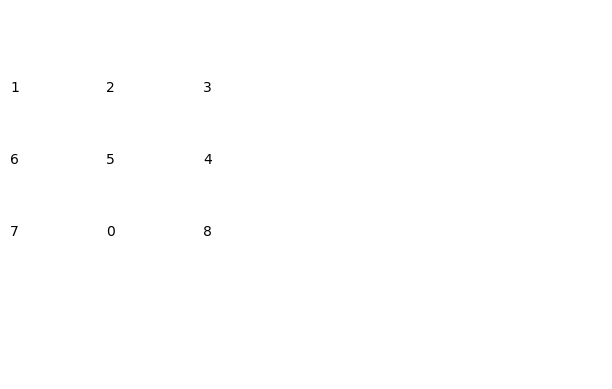

In [320]:
for n, i in enumerate(norm_coords):
    x = i[0]/10000
    y = i[1]/10000
    s = n
    plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')


(0.0, 1.0, 0.0, 1.0)

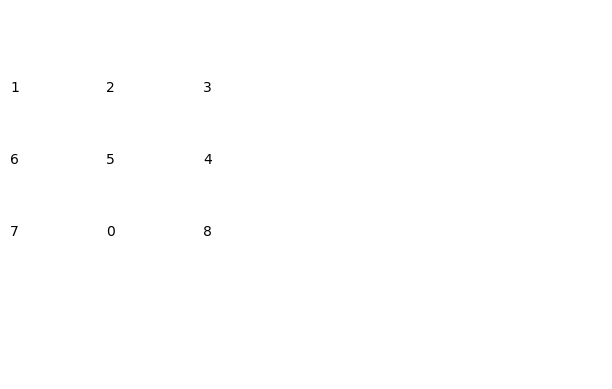

In [321]:
for n, i in enumerate(transforms):
    x = i[0,2]/10000
    y = i[1,2]/10000
    s = n
    plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')

Transforms seem correct...

In [322]:
for n, tile in enumerate(tiles):
    for xy in tile:
        x = xy[0]/10000
        y = xy[1]/10000
        s = n
        plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')

(0.0, 1.0, 0.0, 1.0)

tiles are correct

In [323]:
for n, tile in enumerate(shifted_tiles):
    for xy in tile:
        x = xy[0]/10000
        y = xy[1]/10000
        s = n
        plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')

(0.0, 1.0, 0.0, 1.0)

shifted tiles are correct

In [328]:
for n, tile in enumerate(tiles_shifted_shapely):
    x,y = tile.exterior.xy
    plt.plot(x,y, )
    plt.text(x[0]+1000,y[0]-1000, s=n)

# The numpy shape to shapely function rotates the mosaic... but not an issue

# Incorrect chunks? I believe the issue is between tile and chunks

In [329]:
for n, tile in enumerate(chunk_shapes):
    for xy in tile:
        x = xy[0]/10000
        y = xy[1]/10000
        s = n
        plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')

(0.0, 1.0, 0.0, 1.0)

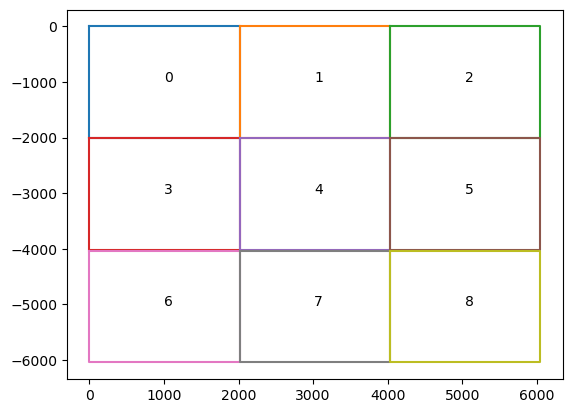

In [330]:
for n, tile in enumerate(chunks_shapely):
    x,y = tile.exterior.xy
    plt.plot(x,y, )
    plt.text(x[0]+1000,y[0]-1000, s=n)

In [331]:
for i in chunk_tiles:
    fn = chunk_tiles[i][0][0]
    fn = re.search('Replication_IPSDM_GFP/Images/r03c05f(\d+)', fn).group(1)
    x = chunk_tiles[i][0][1][0,2]/10000
    y = chunk_tiles[i][0][1][1,2]/10000
    s = fn
    plt.text(x = x, y = y, s = s)


In [332]:
chunk_tiles

{(0,
  0): [('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f01p01-ch1sk1fk1fl1.tiff',
   array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
          [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f06p01-ch1sk1fk1fl1.tiff',
   array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
          [0.00000000e+00, 1.00000000e+00, 1.94399749e+03],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f08p01-ch1sk1fk1fl1.tiff',
   array([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]])), ('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f07p01-ch1sk1fk1fl1.tiff',
   array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 1.00000000e+

# Running through the function, line by line, and checking the output

In [12]:
load_transform_image = partial(load_image, transforms=input_transforms)

In [13]:
filtered_df = df[(df['TimepointID'] == str(time))
               &(df['PlaneID'] == str(plane))
               &(df['ChannelID'] == str(channel))
               &(df['Row'] == str(row))
               &(df['Col'] == str(col))
                ]
filtered_df

id State                             URL Row Col FieldID  \
108  0305K1F1P1R1    Ok  r03c05f01p01-ch1sk1fk1fl1.tiff   3   5       1   
114  0305K1F2P1R1    Ok  r03c05f02p01-ch1sk1fk1fl1.tiff   3   5       2   
120  0305K1F3P1R1    Ok  r03c05f03p01-ch1sk1fk1fl1.tiff   3   5       3   
126  0305K1F4P1R1    Ok  r03c05f04p01-ch1sk1fk1fl1.tiff   3   5       4   
132  0305K1F5P1R1    Ok  r03c05f05p01-ch1sk1fk1fl1.tiff   3   5       5   
138  0305K1F6P1R1    Ok  r03c05f06p01-ch1sk1fk1fl1.tiff   3   5       6   
144  0305K1F7P1R1    Ok  r03c05f07p01-ch1sk1fk1fl1.tiff   3   5       7   
150  0305K1F8P1R1    Ok  r03c05f08p01-ch1sk1fk1fl1.tiff   3   5       8   
156  0305K1F9P1R1    Ok  r03c05f09p01-ch1sk1fk1fl1.tiff   3   5       9   

    PlaneID TimepointID ChannelID FlimID  ... PositionZ AbsPositionZ  \
108       1           0         1      1  ...         0  0.135621503   
114       1           0         1      1  ...         0  0.135619298   
120       1           0         1      1  ...         0  0.135619998   
126       1           0         1      1  ...         0  0.135619894   
132       1           0         1      1  ...         0  0.135621503   
138       1           0         1      1  ...         0  0.135620698   
144       1           0         1      1  ...         0  0.135620698   
150       1           0         1      1  ...         0  0.135621101   
156       1           0         1      1  ...         0  0.135621995   

    MeasurementTimeOffset                        AbsTime  \
108                     0   2021-04-16T19:11:18.61+01:00   
114                     0  2021-04-16T19:11:19.903+01:00   
120                     0  2021-04-16T19:11:21.183+01:00   
126                     0  2021-04-16T19:11:22.773+01:00   
132                     0  2021-04-16T19:11:24.117+01:00   
138                     0   2021-04-16T19:11:25.41+01:00   
144                     0  2021-04-16T19:11:26.707+01:00   
150                     0      2021-04-16T19:11:28+01:00   
156                     0   2021-04-16T19:11:29.31+01:00   

    MainExcitationWavelength MainEmissionWavelength ObjectiveMagnification  \
108                      488                    522                     40   
114                      488                    522                     40   
120                      488                    522                     40   
126                      488                    522                     40   
132                      488                    522                     40   
138                      488                    522                     40   
144                      488                    522                     40   
150                      488                    522                     40   
156                      488                    522                     40   

    ObjectiveNA ExposureTime  \
108         1.1          0.1   
114         1.1          0.1   
120         1.1          0.1   
126         1.1          0.1   
132         1.1          0.1   
138         1.1          0.1   
144         1.1          0.1   
150         1.1          0.1   
156         1.1          0.1   

                                     OrientationMatrix  
108  [[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0...  
114  [[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0...  
120  [[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0...  
126  [[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0...  
132  [[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0...  
138  [[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0...  
144  [[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0...  
150  [[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0...  
156  [[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0...  

[9 rows x 35 columns]

In [14]:
fns = filtered_df['URL']
fns

108    r03c05f01p01-ch1sk1fk1fl1.tiff
114    r03c05f02p01-ch1sk1fk1fl1.tiff
120    r03c05f03p01-ch1sk1fk1fl1.tiff
126    r03c05f04p01-ch1sk1fk1fl1.tiff
132    r03c05f05p01-ch1sk1fk1fl1.tiff
138    r03c05f06p01-ch1sk1fk1fl1.tiff
144    r03c05f07p01-ch1sk1fk1fl1.tiff
150    r03c05f08p01-ch1sk1fk1fl1.tiff
156    r03c05f09p01-ch1sk1fk1fl1.tiff
Name: URL, dtype: object

In [15]:
fns = [glob.glob(os.path.join(image_dir, fn))[0] for fn in fns]
fns

['/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f01p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f02p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f03p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f04p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f05p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f06p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f07p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f08p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f09p01-ch1sk1fk1fl1

In [16]:
sample = imread(fns[0])
sample

array([[ 100,  105,  105, ...,  110,  103,  110],
       [  96,  104,  104, ...,  100,  100,  103],
       [  97,   97,  105, ...,   98,   97,   99],
       ...,
       [ 939,  986, 1027, ...,  450,  446,  443],
       [ 918,  988, 1007, ...,  434,  442,  455],
       [ 903, 1010, 1058, ...,  440,  479,  492]], dtype=uint16)

In [17]:
sample.shape

(2160, 2160)

In [18]:
lazy_arrays = [dask.delayed(imread)(fn) for fn in fns]
lazy_arrays

[Delayed('imread-e0ecb003-761f-4cb1-a473-4113c3f4cfba'),
 Delayed('imread-1447ec38-02f2-4bbd-9a2c-1bc9a2905ccf'),
 Delayed('imread-cafee1ce-5329-43be-84d7-1a635afe3f6a'),
 Delayed('imread-544a5c52-cf76-4b70-8288-b63c63932a46'),
 Delayed('imread-8be5d0fe-301c-4ba0-9df6-4608916d63ef'),
 Delayed('imread-b6fa4c8c-3195-4a9b-a709-a1adf5ef7e92'),
 Delayed('imread-3e8ea393-fbcb-4161-b1c3-cfed37afbcda'),
 Delayed('imread-82994c30-95dd-4bd6-8f28-60db2979f173'),
 Delayed('imread-19cb9387-8f26-41c7-82fe-d0836ef2f5d4')]

In [19]:
lazy_arrays = [dask.array.from_delayed(x, shape=sample.shape, dtype=sample.dtype)
               for x in lazy_arrays]
lazy_arrays

[dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>]

In [20]:
from skimage.io import imshow

In [21]:
import napari

In [22]:
napari.Viewer().add_image(imread('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f01p01-ch1sk1fk1fl1.tiff'))

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'Image' at 0x7f011d14d640>

In [23]:
imshow(lazy_arrays[0])

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


In [24]:
_fuse_func=partial(fuse_func,
                   imload_fn=load_transform_image,
                   dtype=sample.dtype)

In [25]:
_fuse_func

functools.partial(<function fuse_func at 0x7f018f0dc670>, imload_fn=functools.partial(<function load_image at 0x7f018f0ed310>, transforms=None), dtype=dtype('uint16'))

In [26]:
coords = filtered_df[["URL", "PositionX", "PositionY", "PositionZ",
"ImageResolutionX", "ImageResolutionY"]]
coords

URL     PositionX    PositionY PositionZ  \
108  r03c05f01p01-ch1sk1fk1fl1.tiff             0  0.000581233         0   
114  r03c05f02p01-ch1sk1fk1fl1.tiff  -0.000290616  0.001162465         0   
120  r03c05f03p01-ch1sk1fk1fl1.tiff             0  0.001162465         0   
126  r03c05f04p01-ch1sk1fk1fl1.tiff   0.000290616  0.001162465         0   
132  r03c05f05p01-ch1sk1fk1fl1.tiff   0.000290616  0.000871849         0   
138  r03c05f06p01-ch1sk1fk1fl1.tiff             0  0.000871849         0   
144  r03c05f07p01-ch1sk1fk1fl1.tiff  -0.000290616  0.000871849         0   
150  r03c05f08p01-ch1sk1fk1fl1.tiff  -0.000290616  0.000581233         0   
156  r03c05f09p01-ch1sk1fk1fl1.tiff   0.000290616  0.000581233         0   

           ImageResolutionX        ImageResolutionY  
108  1.4949402023919043E-07  1.4949402023919043E-07  
114  1.4949402023919043E-07  1.4949402023919043E-07  
120  1.4949402023919043E-07  1.4949402023919043E-07  
126  1.4949402023919043E-07  1.4949402023919043E-07  
132  1.4949402023919043E-07  1.4949402023919043E-07  
138  1.4949402023919043E-07  1.4949402023919043E-07  
144  1.4949402023919043E-07  1.4949402023919043E-07  
150  1.4949402023919043E-07  1.4949402023919043E-07  
156  1.4949402023919043E-07  1.4949402023919043E-07

(0.5, 1.0)

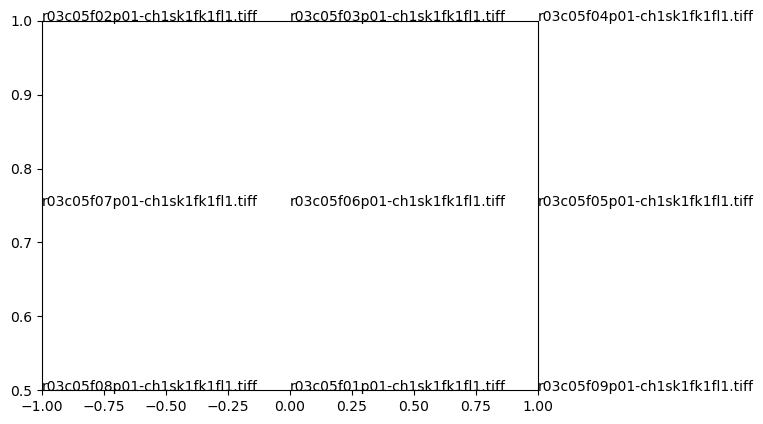

In [27]:
for i in coords.iterrows():
    x = float(i[1]['PositionX'])/0.000290616
    y = float(i[1]['PositionY'])/0.001162465
    s = i[1]['URL']
    plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
plt.xlim(-1,1)
plt.ylim(0.5,1)

In [28]:
coords['PositionXPix'] = (coords['PositionX'].astype(float))/(coords['ImageResolutionX']).astype(float)
coords['PositionYPix'] = (coords['PositionY'].astype(float))/(coords['ImageResolutionY']).astype(float)

In [29]:
import re

(0.0, 1.0, 0.0, 1.0)

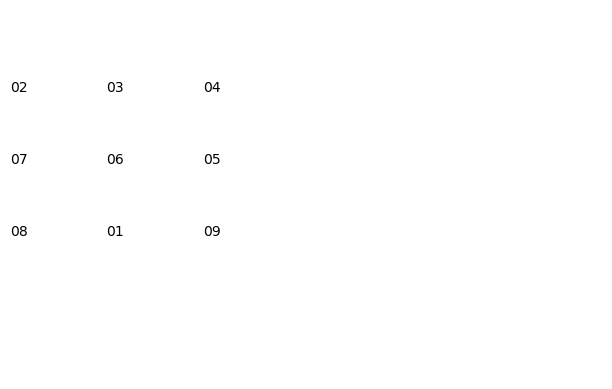

In [30]:
for i in coords.iterrows():
    x = float(i[1]['PositionXPix'])/10000
    y = float(i[1]['PositionYPix'])/10000
    s = i[1]['URL']
    fn = re.search('r03c05f(\d+)', s).group(1)
    plt.text(x = x, y = y, s = fn)
    #plt.text(x = x, y = y, s = 'O', size = 20)
plt.axis('off')

In [31]:
norm_coords = list(zip(coords['PositionXPix'], coords['PositionYPix']))

(0.0, 1.0, 0.0, 1.0)

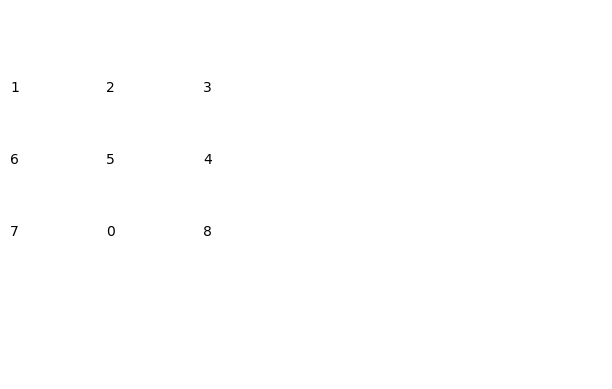

In [32]:
for n, i in enumerate(norm_coords):
    x = i[0]/10000
    y = i[1]/10000
    s = n
    plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')

In [33]:
transforms = [AffineTransform(translation=stage_coord).params for stage_coord in norm_coords]
transforms

[array([[ 1.00000000e+00, -0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  3.88800167e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -0.00000000e+00, -1.94399749e+03],
        [ 0.00000000e+00,  1.00000000e+00,  7.77599665e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  7.77599665e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -0.00000000e+00,  1.94399749e+03],
        [ 0.00000000e+00,  1.00000000e+00,  7.77599665e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -0.00000000e+00,  1.94399749e+03],
        [ 0.00000000e+00,  1.00000000e+00,  5.83199916e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 1.00000000e+00, -0.00000000e+00,  0.00000000e+00],
        [ 0.00

(0.0, 1.0, 0.0, 1.0)

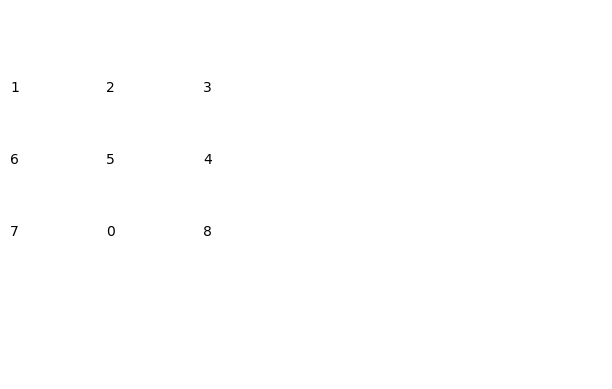

In [34]:
for n, i in enumerate(transforms):
    x = i[0,2]/10000
    y = i[1,2]/10000
    s = n
    plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')

In [35]:
tiles = [transform_tile_coord(sample.shape, transform) for transform in transforms]
tiles

[array([[   0.        , 3888.00166769],
        [2160.        , 3888.00166769],
        [2160.        , 6048.00166769],
        [   0.        , 6048.00166769]]),
 array([[-1943.99748923,  7775.99664615],
        [  216.00251077,  7775.99664615],
        [  216.00251077,  9935.99664615],
        [-1943.99748923,  9935.99664615]]),
 array([[   0.        , 7775.99664615],
        [2160.        , 7775.99664615],
        [2160.        , 9935.99664615],
        [   0.        , 9935.99664615]]),
 array([[1943.99748923, 7775.99664615],
        [4103.99748923, 7775.99664615],
        [4103.99748923, 9935.99664615],
        [1943.99748923, 9935.99664615]]),
 array([[1943.99748923, 5831.99915692],
        [4103.99748923, 5831.99915692],
        [4103.99748923, 7991.99915692],
        [1943.99748923, 7991.99915692]]),
 array([[   0.        , 5831.99915692],
        [2160.        , 5831.99915692],
        [2160.        , 7991.99915692],
        [   0.        , 7991.99915692]]),
 array([[-1943.99748

In [36]:
for n, tile in enumerate(tiles):
    for xy in tile:
        x = xy[0]/10000
        y = xy[1]/10000
        s = n
        plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')

(0.0, 1.0, 0.0, 1.0)

In [37]:
all_bboxes = np.vstack(tiles)
all_bboxes

array([[    0.        ,  3888.00166769],
       [ 2160.        ,  3888.00166769],
       [ 2160.        ,  6048.00166769],
       [    0.        ,  6048.00166769],
       [-1943.99748923,  7775.99664615],
       [  216.00251077,  7775.99664615],
       [  216.00251077,  9935.99664615],
       [-1943.99748923,  9935.99664615],
       [    0.        ,  7775.99664615],
       [ 2160.        ,  7775.99664615],
       [ 2160.        ,  9935.99664615],
       [    0.        ,  9935.99664615],
       [ 1943.99748923,  7775.99664615],
       [ 4103.99748923,  7775.99664615],
       [ 4103.99748923,  9935.99664615],
       [ 1943.99748923,  9935.99664615],
       [ 1943.99748923,  5831.99915692],
       [ 4103.99748923,  5831.99915692],
       [ 4103.99748923,  7991.99915692],
       [ 1943.99748923,  7991.99915692],
       [    0.        ,  5831.99915692],
       [ 2160.        ,  5831.99915692],
       [ 2160.        ,  7991.99915692],
       [    0.        ,  7991.99915692],
       [-1943.99

(0.0, 1.0, 0.0, 1.0)

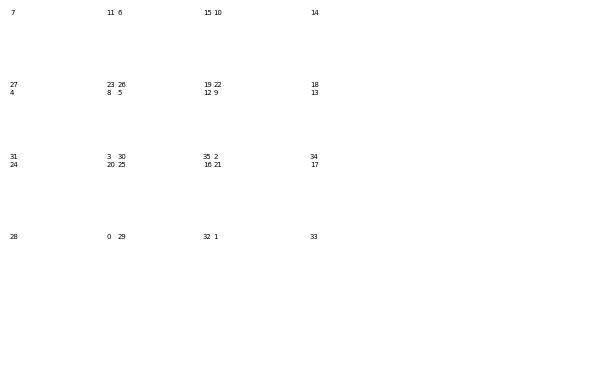

In [38]:
for n, bbox in enumerate(all_bboxes):
    x = bbox[0]/10000
    y = bbox[1]/10000
    s = n
    plt.text(x = x, y = y, s = s, size = 5)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')

In [40]:
all_min = all_bboxes.min(axis=0)
all_max = all_bboxes.max(axis=0)


In [41]:
all_min

array([-1943.99748923,  3888.00166769])

In [42]:
all_max

array([4103.99748923, 9935.99664615])

In [43]:
stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))


In [44]:
stitched_shape

(6048, 6048)

In [45]:
shift_to_origin = AffineTransform(translation=-all_min)

In [46]:
shift_to_origin

<AffineTransform(matrix=
    [[ 1.00000000e+00, -0.00000000e+00,  1.94399749e+03],
     [ 0.00000000e+00,  1.00000000e+00, -3.88800167e+03],
     [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]) at 0x7f0139596490>

In [47]:
transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
transforms_with_shift

[array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.00000000e+00, 3.88799498e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
        [0.00000000e+00, 1.00000000e+00, 3.88799498e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[1.00000000e+00, 0.00000000e+00, 3.88799498e+03],
        [0.00000000e+00, 1.00000000e+00, 3.88799498e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[1.00000000e+00, 0.00000000e+00, 3.88799498e+03],
        [0.00000000e+00, 1.00000000e+00, 1.94399749e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
        [0.00000000e+00, 1.00000000e+00, 1.94399749e+03],
    

In [54]:
for n, i in enumerate(transforms_with_shift):
    x = i[0,2]/10000
    y = i[1,2]/10000
    s = n
    plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')

(0.0, 1.0, 0.0, 1.0)

In [55]:
shifted_tiles = [transform_tile_coord(sample.shape, t) for t in transforms_with_shift]

In [62]:
for n, tile in enumerate(shifted_tiles):
    for xy in tile:
        x = xy[0]/10000
        y = xy[1]/10000
        s = n
        plt.text(x = x, y = y, s = s)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')

(0.0, 1.0, 0.0, 1.0)

In [63]:
chunk_size = (stitched_shape[0]/np.sqrt(chunk_fraction),stitched_shape[0]/np.sqrt(chunk_fraction))
chunks = normalize_chunks(chunk_size,shape=tuple(stitched_shape))

In [66]:
chunk_size, stitched_shape

((2016.0, 2016.0), (6048, 6048))

In [65]:
chunks

((2016, 2016, 2016), (2016, 2016, 2016))

In [67]:
computed_shape = np.array(list(map(sum, chunks)))

In [68]:
computed_shape

array([6048, 6048])

In [70]:
assert np.all(np.array(stitched_shape) == computed_shape)
np.all(np.array(stitched_shape) == computed_shape)

True

In [71]:
chunk_boundaries = list(get_chunk_coord(stitched_shape, chunk_size))

In [94]:
chunk_boundaries

[((0, 2016), (0, 2016)),
 ((0, 2016), (2016, 4032)),
 ((0, 2016), (4032, 6048)),
 ((2016, 4032), (0, 2016)),
 ((2016, 4032), (2016, 4032)),
 ((2016, 4032), (4032, 6048)),
 ((4032, 6048), (0, 2016)),
 ((4032, 6048), (2016, 4032)),
 ((4032, 6048), (4032, 6048))]

0.0 0.2016
0.0 0.2016
0.0 0.2016
0.2016 0.4032
0.0 0.2016
0.4032 0.6048
0.2016 0.4032
0.0 0.2016
0.2016 0.4032
0.2016 0.4032
0.2016 0.4032
0.4032 0.6048
0.4032 0.6048
0.0 0.2016
0.4032 0.6048
0.2016 0.4032
0.4032 0.6048
0.4032 0.6048


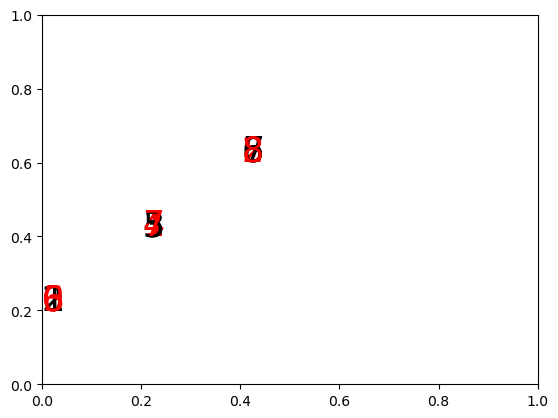

In [95]:
for n, chunk in enumerate(chunk_boundaries):
    x1 = chunk[0][0]/10000
    y1 = chunk[0][1]/10000
    x2 = chunk[1][0]/10000
    y2 = chunk[1][1]/10000
    print(x1,y1)
    print(x2,y2)
    plt.text(x =x1, y=y1, s=n, size = 25)
    plt.text(x =x2, y=y2, s=n, color = 'red', size = 25)

In [214]:
for n, chunk_boundary in enumerate(chunk_boundaries):
    anchor_point = (chunk_boundary[0][0]/10000, chunk_boundary[1][0]/10000)
    x = anchor_point[0]
    y = anchor_point[1]
    plt.text(x =x, y=y, s=n, size = 25)
 


# what the hell is going on with chunk boundaries?

In [96]:
chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))


In [99]:
for n, tile in enumerate(chunk_shapes):
    for xy in tile:
        x = xy[0]/10000
        y = xy[1]/10000
        s = n
        plt.text(x = x, y = y, s = s, size = 20)
    #plt.text(x = x, y = y, s = 'O', size = 20)
# plt.xlim(-1,1)
# plt.ylim(0.5,1)
plt.axis('off')

(0.0, 1.0, 0.0, 1.0)

In [100]:
tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]

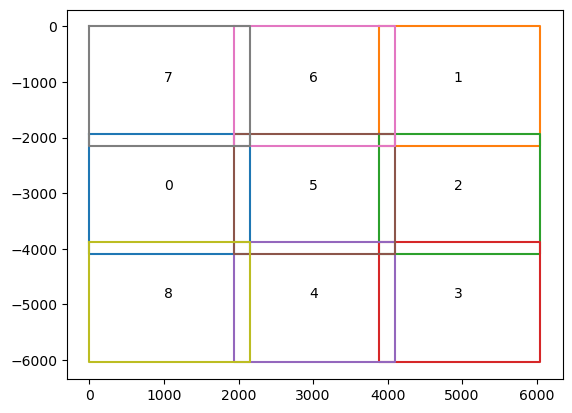

In [101]:
for n, tile in enumerate(tiles_shifted_shapely):
    x,y = tile.exterior.xy
    plt.plot(x,y, )
    plt.text(x[0]+1000,y[0]-1000, s=n)

# so the shifted tiles reorientate them according to python rowcol indexing...

In [102]:
chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]

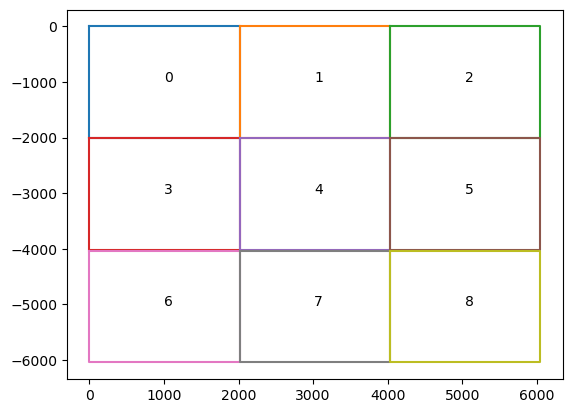

In [103]:
for n, tile in enumerate(chunks_shapely):
    x,y = tile.exterior.xy
    plt.plot(x,y, )
    plt.text(x[0]+1000,y[0]-1000, s=n)

# chunks are similarly reorientated but with a different order
# could there be both an indexing error (i.e. 0 = 1) and a orientation error

In [104]:
for tile_shifted_shapely, file, transform in zip(tiles_shifted_shapely,
                                     fns,
                                     transforms_with_shift):
    tile_shifted_shapely.fuse_info = {'file':file,
                                      'transform':transform}

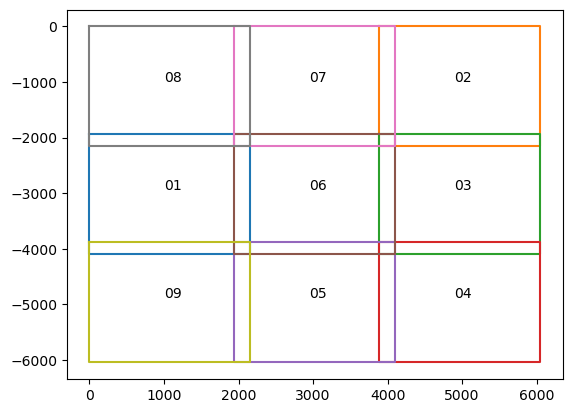

In [117]:
for n, tile in enumerate(tiles_shifted_shapely):
    x,y = tile.exterior.xy
    plt.plot(x,y, )
    fn = tile.fuse_info['file']
    fn = re.search('Replication_IPSDM_GFP/Images/r03c05f(\d+)', fn).group(1)   
    plt.text(x[0]+1000,y[0]-1000, s=fn)

In [118]:
for chunk_shapely, chunk_boundary in zip(chunks_shapely,
                                          chunk_boundaries):
    chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}

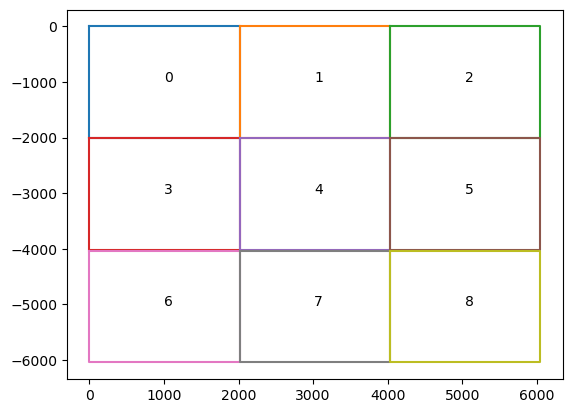

In [120]:
for n, tile in enumerate(chunks_shapely):
    x,y = tile.exterior.xy
    plt.plot(x,y, )
    plt.text(x[0]+1000,y[0]-1000, s=n)

In [172]:
reindex_chunks_shapely = chunks_shapely

In [174]:
reindex_chunks_shapely[0].fuse_info

{'chunk_boundary': ((0, 2016), (0, 2016))}

In [121]:
chunk_tiles = find_chunk_tile_intersections(tiles_shifted_shapely, chunks_shapely)


In [131]:
for i in chunk_tiles[(0,0)]:
    print(i[0])

/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f01p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f06p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f08p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f07p01-ch1sk1fk1fl1.tiff


In [149]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

(0, 0)
(0, 2016)
(0, 4032)
(2016, 0)
(2016, 2016)
(2016, 4032)
(4032, 0)
(4032, 2016)
(4032, 4032)


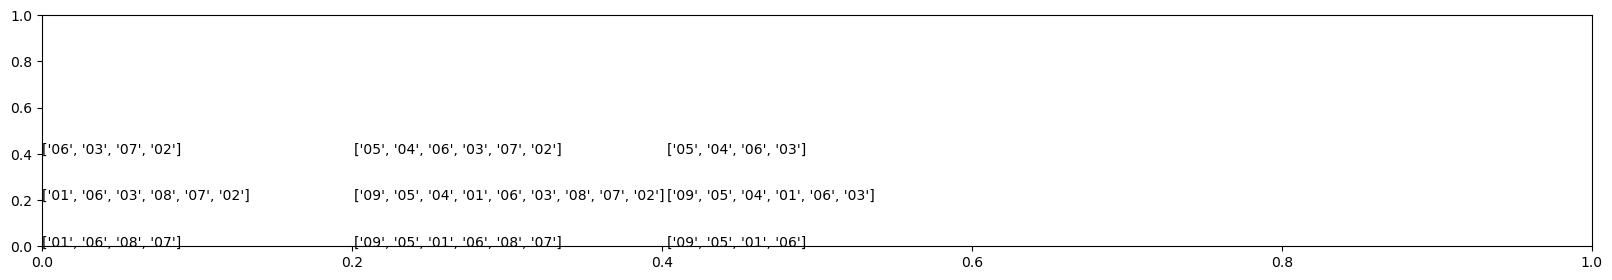

In [150]:
for n, key in enumerate(chunk_tiles):
    print(key)
    x = key[0]/10000
    y = key[1]/10000
    fns = []
#     plt.text(x=x,y=y, s= n)
    for i in chunk_tiles[key]:
        fn = i[0]
        fn = re.search('Replication_IPSDM_GFP/Images/r03c05f(\d+)', fn).group(1)  
        fns.append(fn)
    plt.text(x=x,y=y, s= fns, size = 10)
        


# the order of the tiles does not match the chunks...

inspecting the intersection finding function

In [152]:
tiles_shapely = tiles_shifted_shapely

In [ ]:
tiles

In [170]:
tiles_shapely[0].fuse_info


{'file': '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f01p01-ch1sk1fk1fl1.tiff',
 'transform': array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])}

In [219]:
tile_tree.query(chunk_shape)

In [218]:
chunk_to_tiles = {}
tile_tree = STRtree(tiles_shapely)

for chunk_shape in chunks_shapely:
    chunk_boundary = chunk_shape.fuse_info["chunk_boundary"]
#     print(chunk_boundary)
    anchor_point = (chunk_boundary[0][0], chunk_boundary[1][0])
    print(anchor_point)
    intersecting_tiles = tile_tree.query(chunk_shape)
    chunk_to_tiles[anchor_point] = [
        ((t.fuse_info["file"], t.fuse_info["transform"]))
        for t in intersecting_tiles
    ]

(0, 0)
(0, 2016)
(0, 4032)
(2016, 0)
(2016, 2016)
(2016, 4032)
(4032, 0)
(4032, 2016)
(4032, 4032)


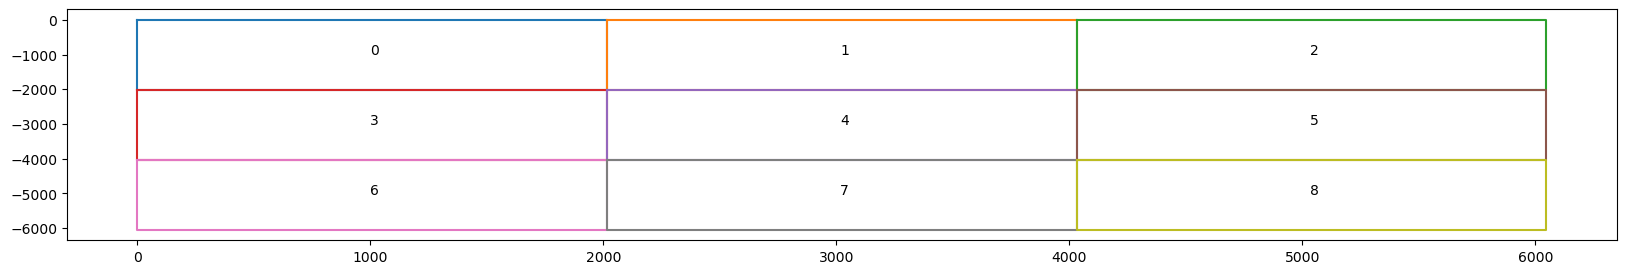

In [207]:
for n, tile in enumerate(chunks_shapely):
    x,y = tile.exterior.xy
    plt.plot(x,y, )
    plt.text(x[0]+1000,y[0]-1000, s=n)

In [166]:
for chunk_shape in chunks_shapely:
    print(chunk_shape)

POLYGON ((0 0, 0 -2015, 2015 -2015, 2015 0, 0 0))
POLYGON ((2016 0, 2016 -2015, 4031 -2015, 4031 0, 2016 0))
POLYGON ((4032 0, 4032 -2015, 6047 -2015, 6047 0, 4032 0))
POLYGON ((0 -2016, 0 -4031, 2015 -4031, 2015 -2016, 0 -2016))
POLYGON ((2016 -2016, 2016 -4031, 4031 -4031, 4031 -2016, 2016 -2016))
POLYGON ((4032 -2016, 4032 -4031, 6047 -4031, 6047 -2016, 4032 -2016))
POLYGON ((0 -4032, 0 -6047, 2015 -6047, 2015 -4032, 0 -4032))
POLYGON ((2016 -4032, 2016 -6047, 4031 -6047, 4031 -4032, 2016 -4032))
POLYGON ((4032 -4032, 4032 -6047, 6047 -6047, 6047 -4032, 4032 -4032))


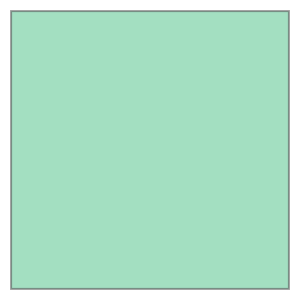

In [165]:
tile_tree.query(chunks_shapely[0])[0]

In [206]:
chunk_tiles = find_chunk_tile_intersections(tiles_shifted_shapely, chunks_shapely)
### tile images together
frame = dask.array.map_blocks(func=_fuse_func,
         chunks=chunks,
         input_tile_info=chunk_tiles,
         dtype=sample.dtype)
view(frame)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f0122ee87c0>

# reindex tiles

In [221]:
tiles_shifted_shapely[0].fuse_info

{'file': '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f01p01-ch1sk1fk1fl1.tiff',
 'transform': array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])}

In [223]:
tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]


In [226]:
len(tiles_shifted_shapely)

9

In [228]:
fns = filtered_df['URL']
fns = [glob.glob(os.path.join(image_dir, fn))[0] for fn in fns]


In [230]:
file

'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f09p01-ch1sk1fk1fl1.tiff'

In [241]:
f = int(re.search('Images/r0(\d+)c0(\d+)f0(\d+)', file).groups()[-1])

9

In [229]:
for tile_shifted_shapely, file, transform in zip(tiles_shifted_shapely,
                                     fns,
                                     transforms_with_shift):
    if 'f01' in file:
        file.replace('f01', 'f08')
    else:
        file.replace('f')
    fn = re.search('Images/r0*c0*f0(\d+)', fn).group(1)  
#     tile_shifted_shapely.fuse_info = {'file':file,
#                                       'transform':transform}
    print(file)

/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f01p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f02p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f03p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f04p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f05p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f06p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f07p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f08p01-ch1sk1fk1fl1.tiff
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c05f09p01-ch1sk1fk1fl1.tiff


In [ ]:
def fuse_func(
    input_tile_info: Dict[
        Tuple[int, int], List[Tuple[Union[str, Path, np.ndarray], np.ndarray]]
    ],
    imload_fn: Optional[Callable] = imread,
    block_info=None,
    dtype=np.uint16,
) -> np.ndarray:

    """
    Fuses the tiles that intersect the current chunk of a dask array using maximum projection.

    Pass this function to dask.array.map_blocks, after partial evaluation of the required
    image_folder and (if needed) optional arguments.

    Returns:
        Array of chunk-shape containing max projection of tiles falling into chunk

    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    array_location = block_info[None]["array-location"]
    # The anchor point is the key to the input_tile_info dictionary
    anchor_point = (array_location[0][0], array_location[1][0])
    chunk_shape = block_info[None]["chunk-shape"]
    tiles_info = input_tile_info[anchor_point]
    #print(f"Processing chunk at {anchor_point}")
    fused = np.zeros(chunk_shape, dtype=dtype)
    for image_representation, tile_affine in tiles_info:
        if imload_fn is not None:
            # When imload_fn is provided we assume we have been given strings representing files
            tile_path = image_representation
            im = imload_fn(tile_path)
        else:
            # Without imload function we assume images are passed
            im = image_representation
        shift = AffineTransform(translation=(-anchor_point[0], -anchor_point[1]))
        tile_shifted = affine_transform(
            im,
            matrix=np.linalg.inv(shift.params @ tile_affine),
            output_shape=chunk_shape,
            cval=0,
        )
        # note that the dtype comversion here happens without scaling
        # may want to use one of the skimage.img_as_* functions instead
        stack = np.stack([fused, tile_shifted.astype(dtype)])
        fused = np.max(stack, axis=0)
    return fused

In [76]:
load_transform_image = partial(load_image, transforms=input_transforms)
filtered_df = df[(df['TimepointID'] == str(time))
               &(df['PlaneID'] == str(plane))
               &(df['ChannelID'] == str(channel))
               &(df['Row'] == str(row))
               &(df['Col'] == str(col))
                ]
### extract filenames for subset
fns = filtered_df['URL']
### build into full file path
fns = [glob.glob(os.path.join(image_dir, fn))[0] for fn in fns]
### stack single slice mosaic into lazy array
sample = imread(fns[0])
lazy_arrays = [dask.delayed(imread)(fn) for fn in fns]
lazy_arrays = [dask.array.from_delayed(x, shape=sample.shape, dtype=sample.dtype)
               for x in lazy_arrays]
### define the function to fuse the image
_fuse_func=partial(fuse_func,
                   imload_fn=load_transform_image,
                   dtype=sample.dtype)
### extract and convert coordinates from standard units into pixels
coords = filtered_df[["URL", "PositionX", "PositionY", "PositionZ",
"ImageResolutionX", "ImageResolutionY"]]
coords['PositionXPix'] = (coords['PositionX'].astype(float))/(coords['ImageResolutionX']).astype(float)
coords['PositionYPix'] = (coords['PositionY'].astype(float))/(coords['ImageResolutionY']).astype(float)
norm_coords = list(zip(coords['PositionXPix'], coords['PositionYPix']))
### convert tile coordinates into transformation matrices
transforms = [AffineTransform(translation=stage_coord).params for stage_coord in norm_coords]
tiles = [transform_tile_coord(sample.shape, transform) for transform in transforms]
### shift the tile coordinates to the origin
all_bboxes = np.vstack(tiles)
all_min = all_bboxes.min(axis=0)
all_max = all_bboxes.max(axis=0)
stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))
shift_to_origin = AffineTransform(translation=-all_min)
transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
shifted_tiles = [transform_tile_coord(sample.shape, t) for t in transforms_with_shift]
### decide on chunk size as a fraction of total slice size TODO: auto size, assuming symmetric atm
chunk_size = (stitched_shape[0]/np.sqrt(chunk_fraction),stitched_shape[0]/np.sqrt(chunk_fraction))
chunks = normalize_chunks(chunk_size,shape=tuple(stitched_shape))
### check the maths adds up correctly (chunks fit into mosaic)
computed_shape = np.array(list(map(sum, chunks)))
assert np.all(np.array(stitched_shape) == computed_shape)
### get boundary coords of chunks
chunk_boundaries = list(get_chunk_coord(stitched_shape, chunk_size))
### use shapely to find the intersection of the chunks
tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]
### is the coordinate conversions between numpy and shapely causing the issue?
# tiles_shifted_shapely = [Polygon(s) for s in shifted_tiles]
chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]
# chunks_shapely = [Polygon(c) for c in chunk_shapes]
### build dictionary of chunk shape data with filenames and transformations
for tile_shifted_shapely, file, transform in zip(tiles_shifted_shapely,
                                     fns,
                                     transforms_with_shift):
    tile_shifted_shapely.fuse_info = {'file':file,
                                      'transform':transform}
for chunk_shapely, chunk_boundary in zip(chunks_shapely,
                                          chunk_boundaries):
    chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}
chunk_tiles = find_chunk_tile_intersections(tiles_shifted_shapely, chunks_shapely)
### tile images together
frame = dask.array.map_blocks(func=_fuse_func,
         chunks=chunks,
         input_tile_info=chunk_tiles,
         dtype=sample.dtype)
view(frame)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7fedebf839d0>